In [153]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import os
from matplotlib.colors import LogNorm


In [120]:
def get_dirs(PROJECT_NAME,MLmethod,subdir):
    pathtowork="/work/clas12/users/gmat/scipio/projects"
    pathtovolatile="/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects"
    dirs = [d for d in os.listdir(f"{pathtovolatile}/{PROJECT_NAME}/{MLmethod}/postprocess_binned/{subdir}")]
    bindirs = []
    binNames = []
    for d in dirs:
        if ("bru" in d or "sdbnd" in d or "nSidis" in d):
            continue
        else:
            bindirs.append(f"{pathtovolatile}/{PROJECT_NAME}/{MLmethod}/postprocess_binned/{subdir}/{d}")
            binNames.append(d.split('_')[1])
    outdir=f"{pathtowork}/{PROJECT_NAME}/{MLmethod}/migrationPlots"
    return bindirs,binNames,outdir

In [270]:
# Given a string <binName>_<binMin>_<binMax> return a label for the heatmap.
# This involves some rounding
def get_description(string):
    binName, bin_min, bin_max = string.split("_")
    roundDigits=3
    return "{} < {} < {}".format(np.round(float(bin_min.rstrip('0')),roundDigits) , binName, np.round(float(bin_max.rstrip('0')),roundDigits))

def convert_matrix(bin_migration):
    N = len(bin_migration.items())
    CONFUSION=np.zeros((N,N))
    DESCRIPTIONS=[]
    for i,iitems in enumerate(bin_migration.items()):
        DESCRIPTIONS.append(get_description(iitems[0]))
        for j,jitems in enumerate(iitems[1].items()):
             CONFUSION[i,j]=jitems[1]
    return CONFUSION,DESCRIPTIONS

def make_MC_confusion(rootfile,binName,version,outdir):
    
    # Create outdir for storing plots
    if(version==""):
        version="all"
    outdir+="/"+version
    if(not os.path.exists(outdir)):
        os.makedirs(outdir)
        
    # Open the TFile and get a list of the TTree names
    f = ROOT.TFile(rootfile)
    tree_names = list(np.unique([key.GetName() for key in f.GetListOfKeys()]))

    # Initialize a dictionary to store the bin migration information
    bin_migration = {}

    # Loop over the TTree names
    for name in tree_names:
        # Extract the x binning range from the TTree name
        _, bin_min, bin_max = name.split("_")
        bin_min, bin_max = float(bin_min), float(bin_max)

        # Get the TTree using uproot
        tree = uproot.open(f"{rootfile}:{name}")
        
        # Initialize counters for events inside and outside the x bin
        where = {key: 0 for key in tree_names}

        # Get the desired branch
        values = tree[f"true{binName}"].array(library="np")
        
        # Find the events with valid MCmatch (i.e. the Monte Carlo matched all necessary final state particles)
        MCmatch = tree["MCmatch"].array(library="np")
        
        # If version is specified, need to make a runNumber cut
        run = tree["run"].array(library="np")
        if(version=="MC_inbending"):
            values = values[(MCmatch==1) & (run==-11)]
        elif(version=="MC_outbending"):
            values = values[(MCmatch==1) & (run==11)]
        else:
            values = values[(MCmatch==1)]
            
        # Loop over the events in the TTree
        for i,value in enumerate(values):
            # Check if the truex value is inside the x bin
            if bin_min <= value < bin_max:
                where[name] += 1
            else:
              # Find the TTree corresponding to the truex value
              for tname in tree_names:
                _, tmin, tmax = tname.split("_")
                tmin, tmax = float(tmin), float(tmax)
                if tmin <= value < tmax:
                    where[tname] += 1
                    break
        # Calculate the bin migration percentage for this TTree
        total = sum(where.values())
        migration = {key: count / total for key, count in where.items()}

        # Store the bin migration percentage in the dictionary
        bin_migration[name] = migration
    
    CONFUSION,DESCRIPTIONS = convert_matrix(bin_migration)
    
    # Create the figure and the axis
    fig, ax = plt.subplots(1,2,dpi=180,figsize=(8,5),gridspec_kw={'width_ratios': [3,1]})

    BINLABELS=[f"Bin {i+1}" for i in range(len(DESCRIPTIONS))]
    # Use Seaborn to plot the confusion matrix
    sns.heatmap(CONFUSION*100+0.00001, annot=True, xticklabels=BINLABELS, yticklabels=BINLABELS, ax=ax[0],fmt=".2f",cmap="Blues",norm=LogNorm(),annot_kws={"size":8})
    plt.sca(ax[0])
    plt.xticks(rotation=45,fontsize=8)
    plt.yticks(rotation=45,fontsize=8)
    plt.xlabel(f"Reconstructed {binName} Bin")
    plt.ylabel(f"True {binName} Bin")
    plt.subplots_adjust(bottom=0.2, top=0.8)
    # Add the bin descriptions to the right of the plot
    for i, description in enumerate(DESCRIPTIONS):
        ax[1].text(-0.3, 0.9-i/10, f"Bin {i+1}: {description}", va="center")
    ax[1].axis('off')
    plt.savefig(f"{outdir}/migration_{binName}.png")

In [277]:
a=np.array([1,1,0,0,1,1,1])


array([ True,  True, False, False,  True,  True,  True])

In [263]:
# PROJECT_NAME = "pipluspi0_prelim"
# MLmethod = "catboost"
# bin_dirs,binNames,outdir=get_dirs(PROJECT_NAME,MLmethod,"test1d")

In [264]:
# for bin_dir,binName in zip(bin_dirs,binNames):
#     for version in ["" , "MC_inbending" , "MC_outbending"]:
#         make_MC_confusion(bin_dir,binName,version,outdir)

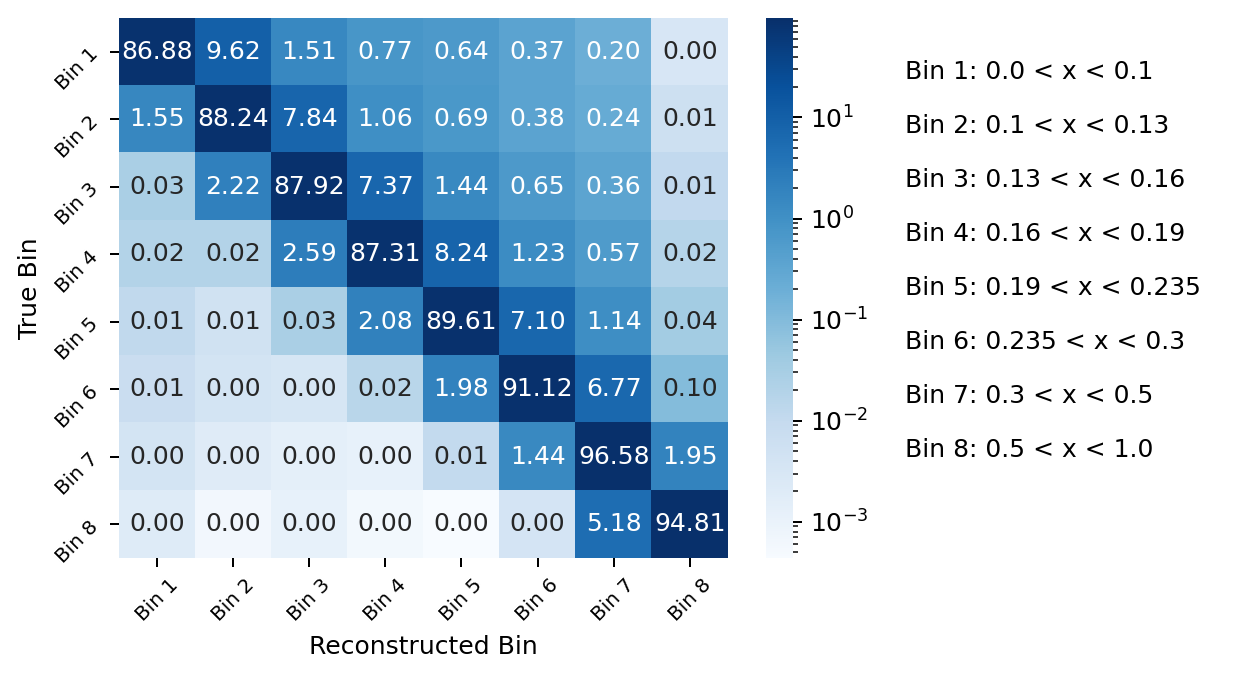

In [269]:
# # Create the figure and the axis
# fig, ax = plt.subplots(1,2,dpi=180,figsize=(8,5),gridspec_kw={'width_ratios': [3,1]})

# BINLABELS=[f"Bin {i+1}" for i in range(len(DESCRIPTIONS))]
# # Use Seaborn to plot the confusion matrix
# sns.heatmap(CONFUSION*100, annot=True, xticklabels=BINLABELS, yticklabels=BINLABELS, ax=ax[0],fmt=".2f",cmap="Blues",norm=LogNorm())
# plt.sca(ax[0])
# plt.xticks(rotation=45,fontsize=8)
# plt.yticks(rotation=45,fontsize=8)
# plt.xlabel("Reconstructed Bin")
# plt.ylabel("True Bin")
# plt.subplots_adjust(bottom=0.2, top=0.8)
# # Add the bin descriptions to the right of the plot
# for i, description in enumerate(DESCRIPTIONS):
#     ax[1].text(-0.3, 0.9-i/10, f"Bin {i+1}: {description}", va="center")

# ax[1].axis('off')
# # Show the plot
# plt.savefig("plot_a.png")

In [271]:
f = ROOT.TFile("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/pipluspi0_prelim/catboost/postprocess_binned/test1d/MC_x_binned.root")
f.ls()

TFile**		/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/pipluspi0_prelim/catboost/postprocess_binned/test1d/MC_x_binned.root	
 TFile*		/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/pipluspi0_prelim/catboost/postprocess_binned/test1d/MC_x_binned.root	
  KEY: TTree	x_0.300000_0.500000;79	x_0.300000_0.500000
  KEY: TTree	x_0.300000_0.500000;78	x_0.300000_0.500000
  KEY: TTree	x_0.235000_0.300000;63	x_0.235000_0.300000
  KEY: TTree	x_0.235000_0.300000;62	x_0.235000_0.300000
  KEY: TTree	x_0.190000_0.235000;57	x_0.190000_0.235000
  KEY: TTree	x_0.190000_0.235000;56	x_0.190000_0.235000
  KEY: TTree	x_0.160000_0.190000;42	x_0.160000_0.190000
  KEY: TTree	x_0.160000_0.190000;41	x_0.160000_0.190000
  KEY: TTree	x_0.130000_0.160000;40	x_0.130000_0.160000
  KEY: TTree	x_0.130000_0.160000;39	x_0.130000_0.160000
  KEY: TTree	x_0.100000_0.130000;29	x_0.100000_0.130000
  KEY: TTree	x_0.100000_0.130000;28	x_0.100000_0.130000
  KEY: TTree	x_0.500000_1.0000